# 1- Maxcut QAOA from scratch, with qiskit

### Creating  a fixed graph

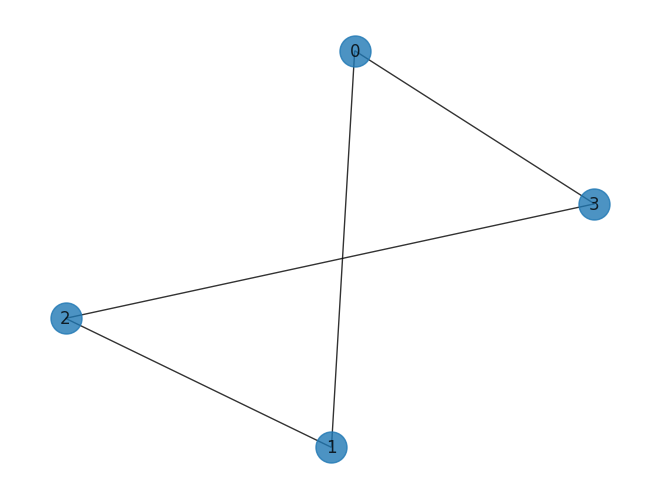

In [1]:
import networkx as nx
graph = nx.Graph()
graph.add_nodes_from([0, 1, 2, 3])
graph.add_edges_from([(0, 1), (1, 2), (2, 3), (3, 0)])
nx.draw(graph, with_labels=True, alpha=0.8, node_size=500)

### Creating the mixing unitary

C:\Users\54299\AppData\Local\Temp\ipykernel_13376\3166346700.py:7: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adjacency = nx.adjacency_matrix(graph).todense()


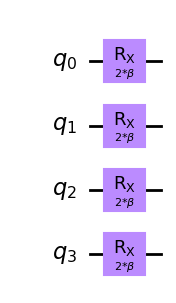

In [2]:
from qiskit import QuantumCircuit, Aer
from qiskit.circuit import Parameter

# Adjacency is essentially a matrix which tells you which nodes are
# connected. This matrix is given as a sparse matrix, so we need to
# convert it to a dense matrix
adjacency = nx.adjacency_matrix(graph).todense()

N_QUBITS = 4

# Estabichs beta parameter used for the rx gates
beta = Parameter("$\\beta$")
qc_mix = QuantumCircuit(N_QUBITS)
for i in range(N_QUBITS):
    qc_mix.rx(2 * beta, i)

qc_mix.draw('mpl')

### Creating the problem unitary

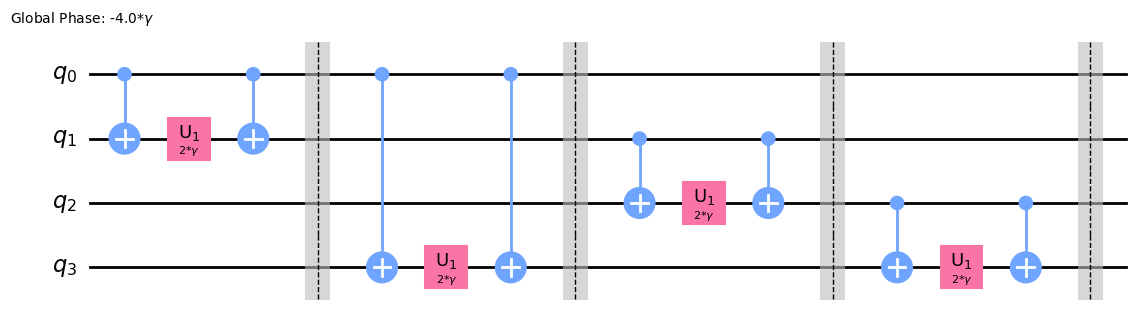

In [3]:
gamma = Parameter("$\\gamma$")
qc_p = QuantumCircuit(N_QUBITS)
for pair in list(graph.edges()):  # pairs of nodes
    #qc_p.rzz(2 * gamma, pair[0], pair[1])
    qc_p.cx(pair[0], pair[1])
    qc_p.rz(2 * gamma,pair[1])
    qc_p.cx(pair[0], pair[1])
    qc_p.barrier()

qc_p.decompose().draw('mpl')

### The initial state

The initial state during QAOA is usually an equal superposition of all the basis states

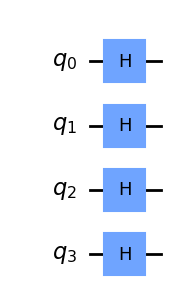

In [4]:
qc_0 = QuantumCircuit(N_QUBITS)
for i in range(N_QUBITS):
    qc_0.h(i)

qc_0.draw('mpl')

### The QAOA quantum circuit

Up to now, we have
* Prepared the initial state
* Applied the unitary corrresponding to the problem Hamiltonian
* Applied the mixing unitary

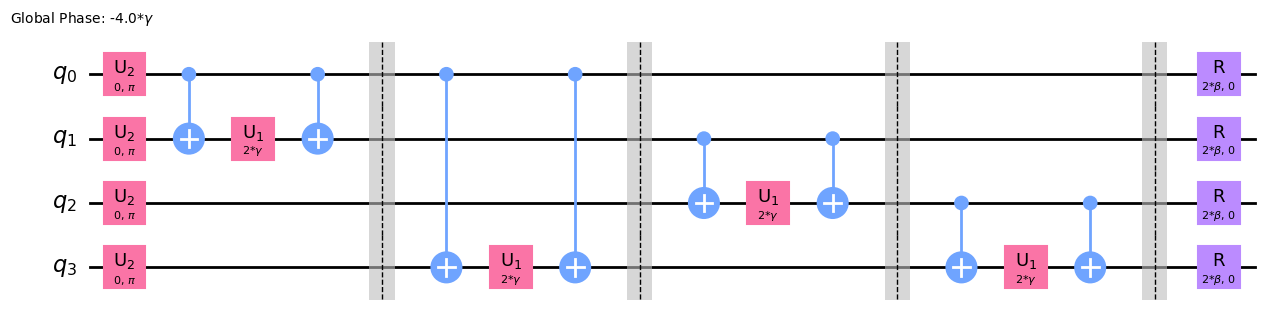

In [5]:
qc_qaoa = QuantumCircuit(N_QUBITS)
qc_qaoa.append(qc_0, range(N_QUBITS))
qc_qaoa.append(qc_p, range(N_QUBITS))
qc_qaoa.append(qc_mix, range(N_QUBITS))

qc_qaoa.decompose().decompose().draw('mpl')

Finally, we have to fin the optimal parameters $(\beta_{opt},\gamma_{opt})$ such that $\langle \psi (\beta_{opt},\gamma_{opt}) | H_P |  \psi (\beta_{opt},\gamma_{opt}) \rangle $ is minimized. For this, we use measurement in the tipical $Z$-basis. After thar we use classical optimization algorithm to the find the optimal parameters.

### The complete QAOA algorithm

Complete with the steps of the algorithm

In [6]:
def maxcut_obj(solution, graph):
    """Given a bit string as a solution, this function returns
    the number of edges shared between the two partitions
    of the graph.
    Args:
        solution: (str) solution bit string
        graph: networkx graph
    Returns:
        obj: (float) Objective
    """
    obj = 0
    for i, j in graph.edges():
        if solution[i] != solution[j]:
            obj -= 1
    return obj

In [7]:
def compute_expectation(counts, graph):
    """Computes expectation value based on measurement results
    Args:
        counts: (dict) key as bit string, val as count
        graph: networkx graph
    Returns:
        avg: float
             expectation value
    """
    avg = 0
    sum_count = 0
    for bit_string, count in counts.items():
        obj = maxcut_obj(bit_string, graph)
        avg += obj * count
        sum_count += count
    return avg/sum_count

In [8]:
# We will also bring the different circuit components that
# build the qaoa circuit under a single function
def create_qaoa_circ(graph, theta):
    """Creates a parametrized qaoa circuit
    Args:
        graph: networkx graph
        theta: (list) unitary parameters
    Returns:
        (QuantumCircuit) qiskit circuit
    """
    nqubits = len(graph.nodes())
    n_layers = len(theta)//2  # number of alternating unitaries
    beta = theta[:n_layers]
    gamma = theta[n_layers:]

    qc = QuantumCircuit(nqubits)

    # initial_state
    qc.h(range(nqubits))

    for layer_index in range(n_layers):
        # problem unitary
        for pair in list(graph.edges()):
            #qc.rzz(2 * gamma[layer_index], pair[0], pair[1])
            qc.cx(pair[0], pair[1])
            qc.rz(2 * gamma[layer_index],pair[1])
            qc.cx(pair[0], pair[1])
        # mixer unitary
        for qubit in range(nqubits):
            qc.rx(2 * beta[layer_index], qubit)

    qc.measure_all()
    return qc

In [9]:
# Finally we write a function that executes the circuit
# on the chosen backend
def get_expectation(graph, shots=512):
    """Runs parametrized circuit
    Args:
        graph: networkx graph
    """
    backend = Aer.get_backend('qasm_simulator')
    backend.shots = shots

    def execute_circ(theta):
        qc = create_qaoa_circ(graph, theta)
        counts = backend.run(qc, seed_simulator=10,
                             nshots=512).result().get_counts()
        return compute_expectation(counts, graph)

    return execute_circ

In [10]:
def create_graph(nodes,edges):
    graph = nx.Graph()
    graph.add_nodes_from(nodes)
    graph.add_edges_from(edges)
    nx.draw(graph, with_labels=True, alpha=0.8, node_size=500)
    return graph

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -3.8505859375
       x: [ 1.999e+00  1.000e+00]
    nfev: 26
   maxcv: 0.0

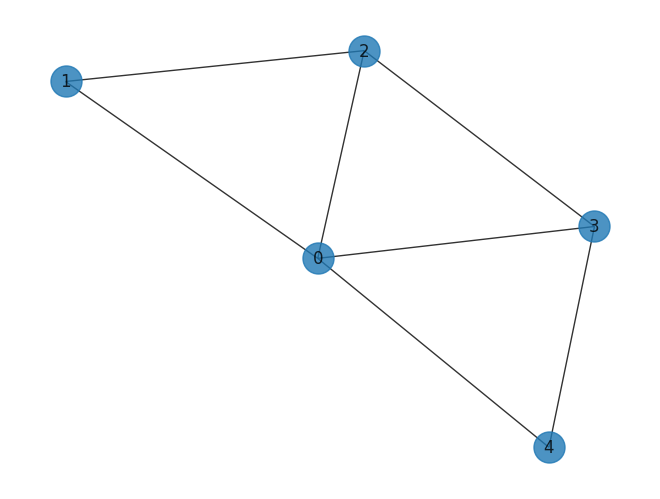

In [11]:
from scipy.optimize import minimize

#taken from https://www.researchgate.net/figure/Cut-example-C-for-an-undirected-graph_fig1_228817519
graph = create_graph(
[0, 1, 2, 3, 4],
[(0, 1), (0, 2), (0, 3), (0, 4), (1, 2), (2, 3), (3, 4)] 
)
expectation = get_expectation(graph)
res = minimize(expectation,
               [1.0, 1.0],
               method='COBYLA')
res
# Different classical optimizers can have different results

Our result optimized the two parameters to values $[ 1.999e+00, 1.000e+00]$. If we use this two values two create the quantum circuit part of the QAOA algorithm, we will see that the most probable results are the answers for the our maxcut problem. That means, the partitions that gives 4 edges between them.

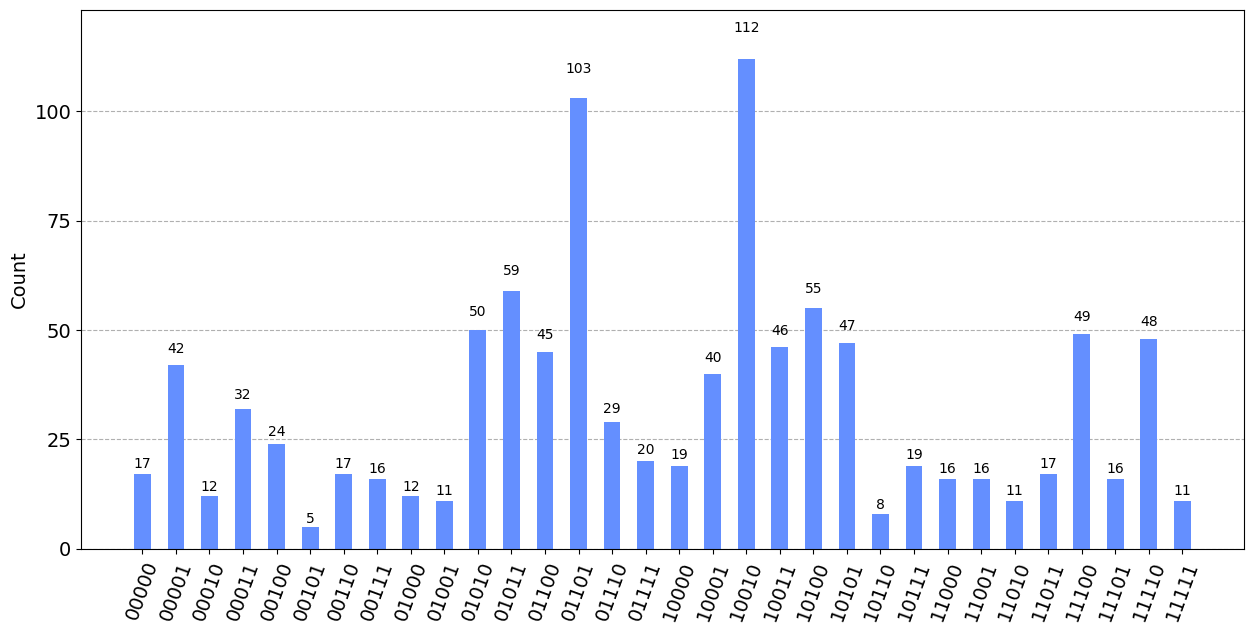

In [12]:
backend = Aer.get_backend('aer_simulator')
backend.shots = 512

from qiskit.visualization import plot_histogram,plot_distribution
qc_res = create_qaoa_circ(graph, res.x)
counts = backend.run(qc_res, seed_simulator=10).result().get_counts()
plot_histogram(counts,figsize=[15,7])

# 2- Simulating and mitigating noise with Mitiq

In [13]:
import matplotlib.pyplot as plt
import numpy as np

import qiskit
from qiskit import QuantumCircuit
from qiskit_aer import Aer, AerSimulator
from qiskit_aer.noise import NoiseModel
from qiskit_aer.noise.errors.standard_errors import (
    depolarizing_error,
)

from mitiq.zne import mitigate_executor
from mitiq.zne.inference import RichardsonFactory

### Create the circuit executor with noise simulated

In [14]:
def get_expectation_with_noise(graph, noise_level=0,shots=512):
    """Runs parametrized circuit
    Args:
        graph: networkx graph
    """
    backend = Aer.get_backend('qasm_simulator')
    backend.shots = shots

    def execute_circ(theta):
        qc = create_qaoa_circ(graph, theta)
        #create the noise model
        noise_model = NoiseModel()
        noise_model.add_all_qubit_quantum_error(
        depolarizing_error(noise_level, 1), ["rx"]
        )
        noise_model.add_all_qubit_quantum_error(
        depolarizing_error(noise_level, 2), ["cx"]
        ) 
        
        #we add the noise model
        counts = backend.run(qc, noise_model=noise_model,seed_simulator=10,
                             nshots=512).result().get_counts()
        return compute_expectation(counts, graph)

    return execute_circ

### QAOA with noise simulated

In [15]:
noise_level = 0.02

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -3.814453125
       x: [ 2.011e+00  1.064e+00]
    nfev: 26
   maxcv: 0.0

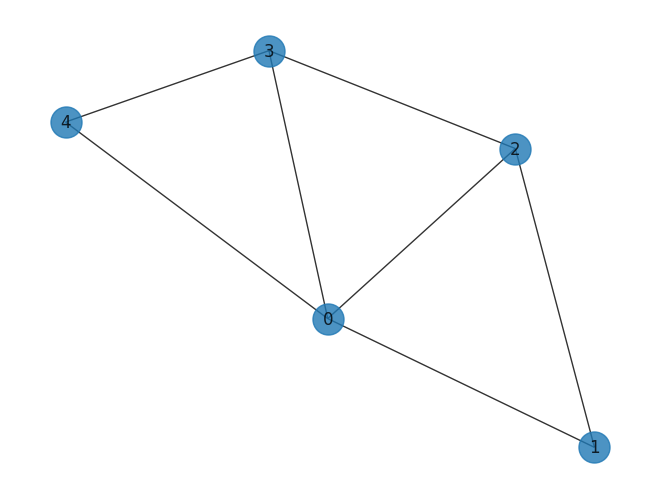

In [16]:
graph = create_graph(
[0, 1, 2, 3, 4],
[(0, 1), (0, 2), (0, 3), (0, 4), (1, 2), (2, 3), (3, 4)] 
)

expectation = get_expectation_with_noise(graph,noise_level=noise_level,shots=10000)
res_noise = minimize(expectation,
               [1.0, 1.0],
               method='COBYLA')
res_noise

### QAOA with noise mitigates with Zero Noise Extrapolation

In [17]:
#this version of get_expectation_with_noise(),instead of receiving the theta list and create the QAOA circuit inside,
#it receives the circuit previously created
def get_expectation_with_noise(graph, noise_level=0,shots=512):
    """Runs parametrized circuit
    Args:
        graph: networkx graph
    """
    backend = Aer.get_backend('qasm_simulator')
    backend.shots = shots
    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(
    depolarizing_error(noise_level, 1), ["rx"]
    )
    noise_model.add_all_qubit_quantum_error(
    depolarizing_error(noise_level, 2), ["cx"]
    ) 

    def execute_circ(qc):
        counts = backend.run(qc, noise_model=noise_model,seed_simulator=10,
                             nshots=shots).result().get_counts()
        
        return compute_expectation(counts, graph)

    return execute_circ

In [18]:
def create_cost_function_for_mitigated_noise(graph,noise_level=0,shots=512):
    #Get noisy expectation(executor)
    expectation = get_expectation_with_noise(graph, noise_level=noise_level,shots=shots)
    
    #create the ZNE mitigated expectation(executor)
    fac = RichardsonFactory(scale_factors=[1, 3, 5])
    mitigated_expectation = mitigate_executor(executor=expectation,factory=fac)
    
    def cost_function_for_mitigated_noise(theta):
        qc = create_qaoa_circ(graph,theta)
        return mitigated_expectation(qc)
    return cost_function_for_mitigated_noise

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -3.886352539062497
       x: [ 2.023e+00  1.046e+00]
    nfev: 34
   maxcv: 0.0

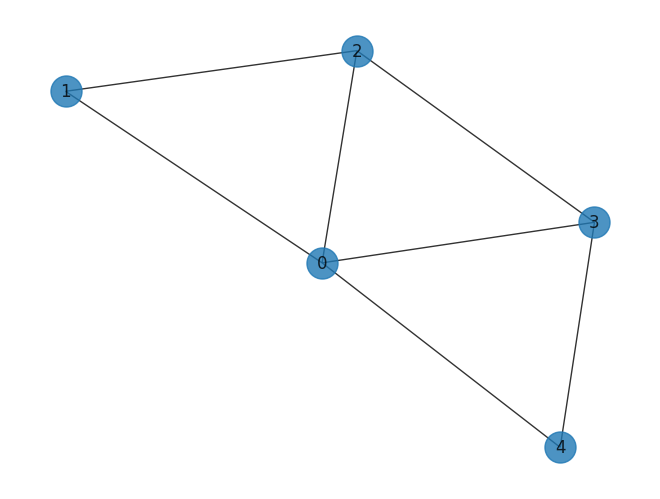

In [19]:
graph = create_graph(
[0, 1, 2, 3, 4],
[(0, 1), (0, 2), (0, 3), (0, 4), (1, 2), (2, 3), (3, 4)] 
)

cost_function = create_cost_function_for_mitigated_noise(graph,noise_level,10000)
res_mitigated = minimize(cost_function,[1.0,1.0],method = 'COBYLA')
res_mitigated

### Comparing results

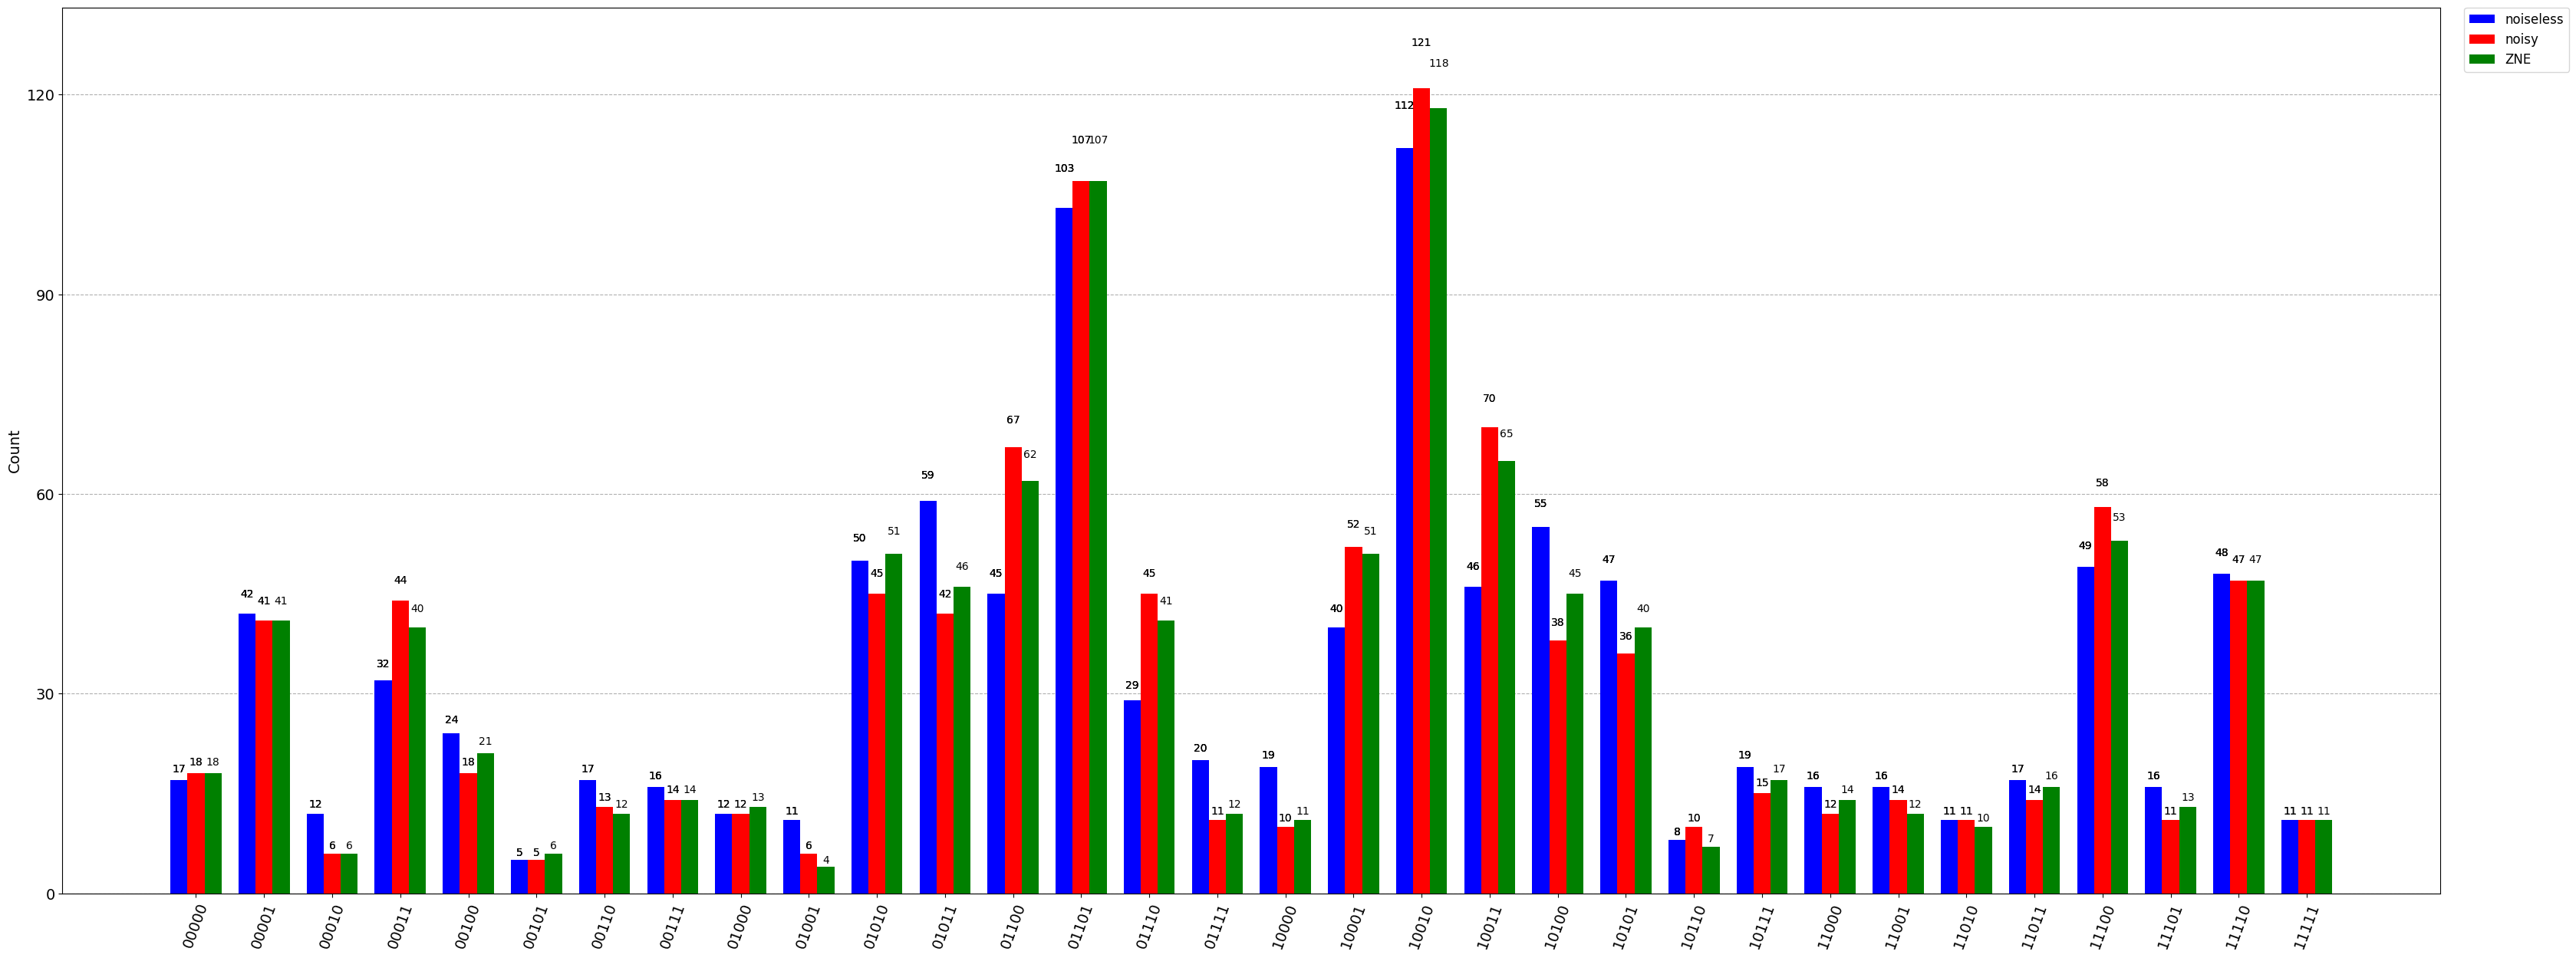

In [20]:
import matplotlib.pyplot as plt
import os

# Obtener la ruta del directorio actual del notebook
notebook_dir = os.getcwd()
# Guardar el gráfico en el mismo directorio que el notebook
filename = 'noiseless vs noisy vs ZNE.png'
filepath = os.path.join(notebook_dir, filename)

backend = Aer.get_backend('aer_simulator')
backend.shots = 512

qc_res_noise = create_qaoa_circ(graph, res_noise.x)
counts_noise = backend.run(qc_res_noise,seed_simulator=10).result().get_counts()

qc_res = create_qaoa_circ(graph, res.x)
counts = backend.run(qc_res, seed_simulator=10).result().get_counts()

qc_res_mitigated = create_qaoa_circ(graph, res_mitigated.x)
counts_mitigated = backend.run(qc_res_mitigated,seed_simulator=10).result().get_counts()

plot_histogram(
    [counts,counts_noise,counts_mitigated],
    color=['blue','red','green'],
    legend=['noiseless','noisy','ZNE'],
    figsize=[70,15],filename=filepath
)
       
display(plot_histogram(
    [counts,counts_noise,counts_mitigated],
    color=['blue','red','green'],
    legend=['noiseless','noisy','ZNE'],
    figsize=[40,15])
    )

# 3- Solving maxcut problem with OpenQAOA

In [21]:
from openqaoa.utilities import plot_graph
from openqaoa.problems import MaximumCut
from openqaoa import QAOA  
from openqaoa.backends import create_device

#REFERENCE FROM https://github.com/fall-fest-latino/escuela-de-computacion-cuantica-2023/blob/main/dia06/Intro_QAOA_Ezequiel_Rodriguez_Chiacchio.ipynb

### Create an instance of a maxcut problem and get its QUBO and cost hamiltonian

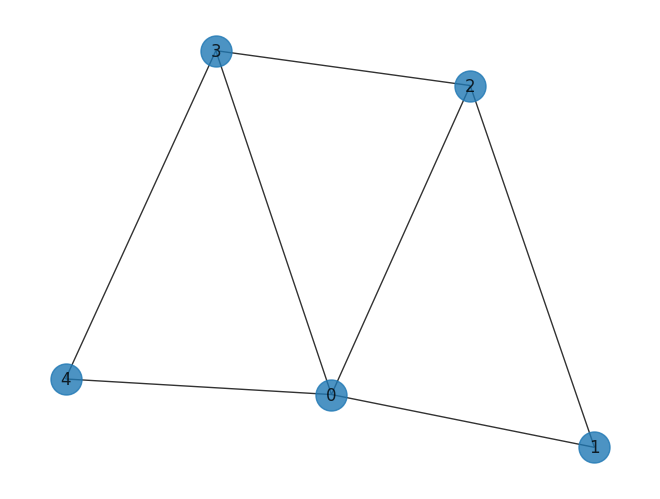

In [22]:
G = create_graph(
[0, 1, 2, 3, 4],
[(0, 1), (0, 2), (0, 3), (0, 4), (1, 2), (2, 3), (3, 4)] 
)

#Inner OpenQAOA function for ploting graphs
#plot_graph(graph)

In [23]:
# Create a MaximumCut instance from the graph and get its QUBO and hamiltonian
maxcut_prob = MaximumCut(G)
maxcut_qubo = maxcut_prob.qubo
maxcut_hamiltonian = maxcut_qubo.hamiltonian

In [24]:
# Can check the problem instance details in the form of a dictionary
maxcut_qubo.asdict()

{'terms': [[0, 1], [0, 2], [0, 3], [0, 4], [1, 2], [2, 3], [3, 4]],
 'weights': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 'constant': 0,
 'n': 5,
 'problem_instance': {'problem_type': 'maximum_cut',
  'G': {'directed': False,
   'multigraph': False,
   'graph': {},
   'nodes': [{'id': 0}, {'id': 1}, {'id': 2}, {'id': 3}, {'id': 4}],
   'links': [{'source': 0, 'target': 1},
    {'source': 0, 'target': 2},
    {'source': 0, 'target': 3},
    {'source': 0, 'target': 4},
    {'source': 1, 'target': 2},
    {'source': 2, 'target': 3},
    {'source': 3, 'target': 4}]}},
 'metadata': {}}

### Creare the QAOA circuit

In [34]:
# initialize model with default configurations
q = QAOA()

In [37]:
# optionally configure the following properties of the model

# device
qiskit_device = create_device(location='local', name='qiskit.statevector_simulator')
q.set_device(qiskit_device)

# circuit properties
q.set_circuit_properties(p=2, param_type='standard', init_type='rand', mixer_hamiltonian='x')
print(q.circuit_properties)
# backend properties (already set by default)
q.set_backend_properties(prepend_state=None, append_state=None)

# classical optimizer properties
q.set_classical_optimizer(method='cobyla', maxiter=200, tol=0.001,
                          optimization_progress=True, cost_progress=True, parameter_log=True)

### Compile and optimize the circuit

In [38]:
q.compile(maxcut_qubo)
q.optimize()

### Access the results

Most probable states: ['10100', '10010', '01101', '01011']
states kept: 32


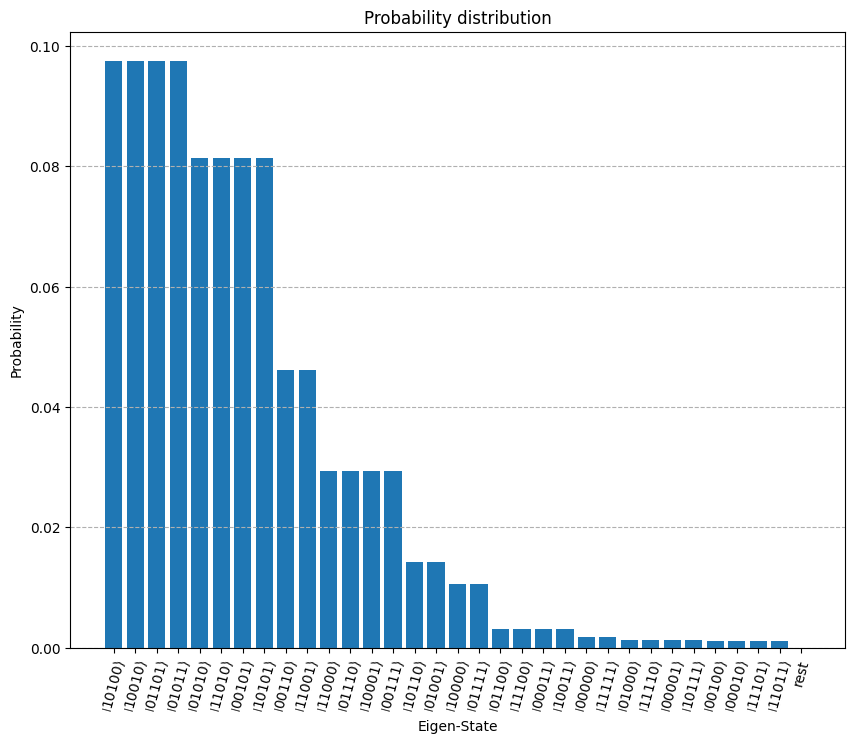

In [39]:
opt_results = q.result
print('Most probable states:',opt_results.most_probable_states['solutions_bitstrings'])
opt_results.plot_probabilities()

In this case, with OpenQAOA we are able to fin four optimal solutions instead of just two.

p=2, param_type='standard', init_type='rand', mixer_hamiltonian='x' :Most probable states : ['10100', '10010', '01101', '01011']

* Increasing amount of layer also increase succes probability (eg 10) but sometines in decrease (eg 15). Probably works like neural networks where you should analyze the optimal amount of steps
* Changing param_type = extended reduce the most probable states to the original two ones, but in counterpart it gives an important increase of succes probability
* fourier param type works bad
* annealing param type gives a bigger amount of optimal answers with a decrease of probability in each one. I didnt calculate if the total amount of success probability is either the same,bigger or smaller than other cases

* Still have to test init_type